In [1]:
#Modules for executing steps of Notebook
import acquire
import explore

In [2]:
#Plotting libraries
import warnings
import matplotlib as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from pylab import rcParams

#Style-settings for Notebook
rcParams['figure.figsize'] = 18, 8
plt.style.use('fivethirtyeight')

In [28]:
#Statistic tools for plots and for scoring
from statsmodels.tsa.seasonal import seasonal_decompose

## ACQUIRE/PREP

Acquire the data from the online source at https://ds.codeup.com/fitbit-data.tar.gz

In [4]:
df = acquire.get_data()

In [5]:
df.Date.nunique()

225

Df2 is the prepared data, with no nulls and with all dtypes are numerical

In [6]:
df2 = acquire.clean_data(df)

In [7]:
df2.head()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2,1347.0,93,0,0,566.0
2018-04-27,3649.0,9971.0,4.70,19,1158.0,219,46,17,1752.0
2018-04-28,3379.0,3521.0,1.66,2,702.0,155,22,11,1124.0
2018-04-29,2851.0,1639.0,0.77,0,891.0,122,0,0,602.0
2018-04-30,2825.0,1323.0,0.62,0,880.0,104,0,0,540.0


Scaled DataFrame if need be

In [8]:
scaled_df = acquire.scale_data(df2)
scaled_df = scaled_df.set_index(df2.index)

# EXPLORE

#### Bird's Eye View of the Dataset

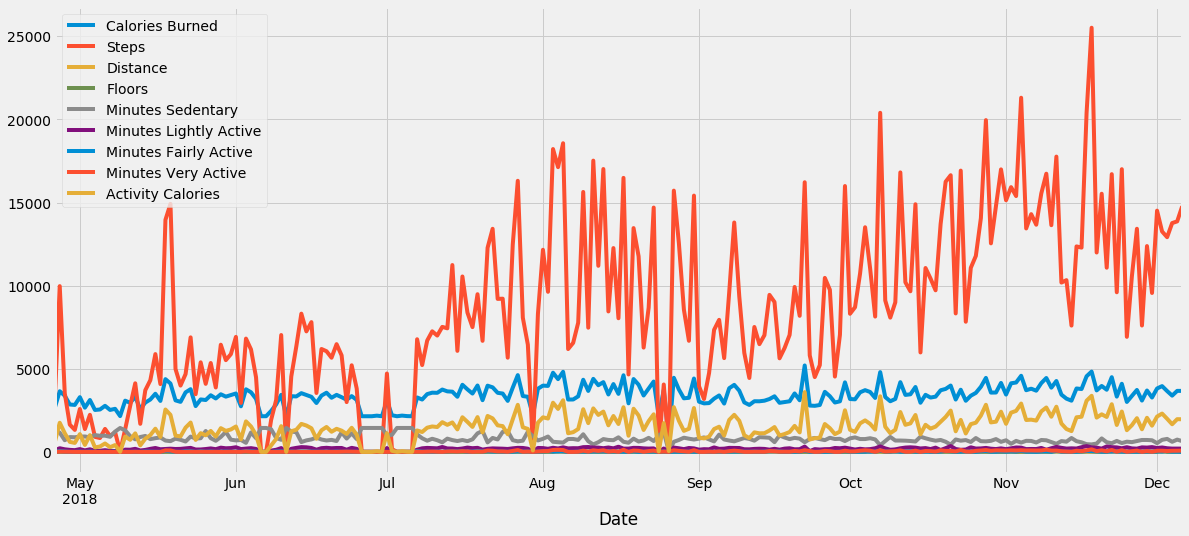

In [9]:
df2.plot()
plt.pyplot.show()

#### Bird's Eye View of the Dataset

#### With scaled data

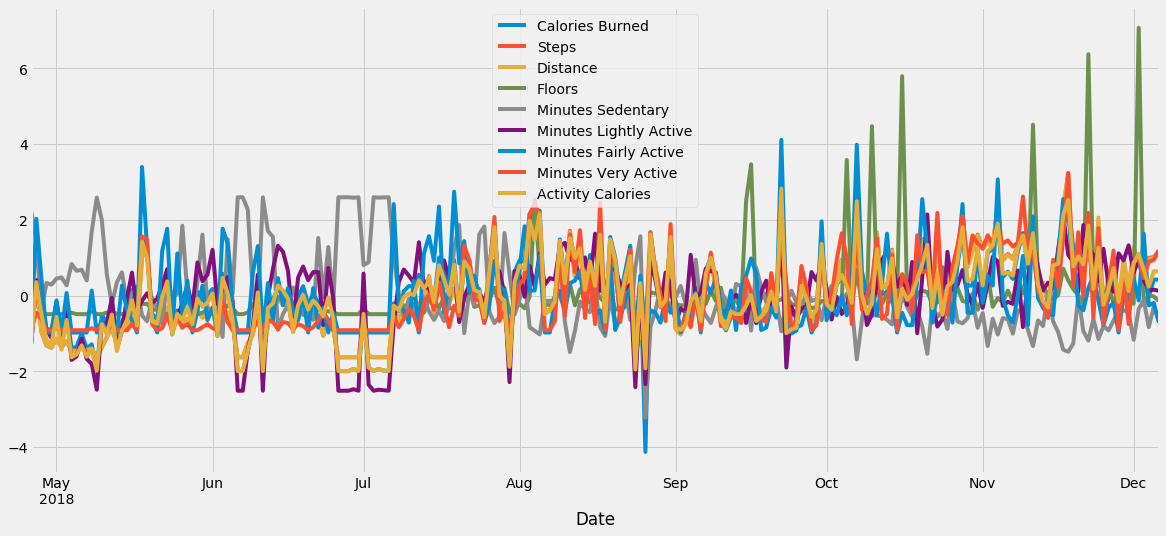

In [10]:
scaled_df.plot()
plt.pyplot.show()

### The day of the EVENT

In [11]:
day_of_event = scaled_df[scaled_df['Calories Burned'] == scaled_df['Calories Burned'].min()]
format_str = '%Y-%m-%d'
blob = day_of_event.index
date_of_event = blob.strftime(format_str)

In [12]:
date_of_event

Index(['2018-08-26'], dtype='object')

In [15]:
event_range = df2['2018-06':'2018-09']

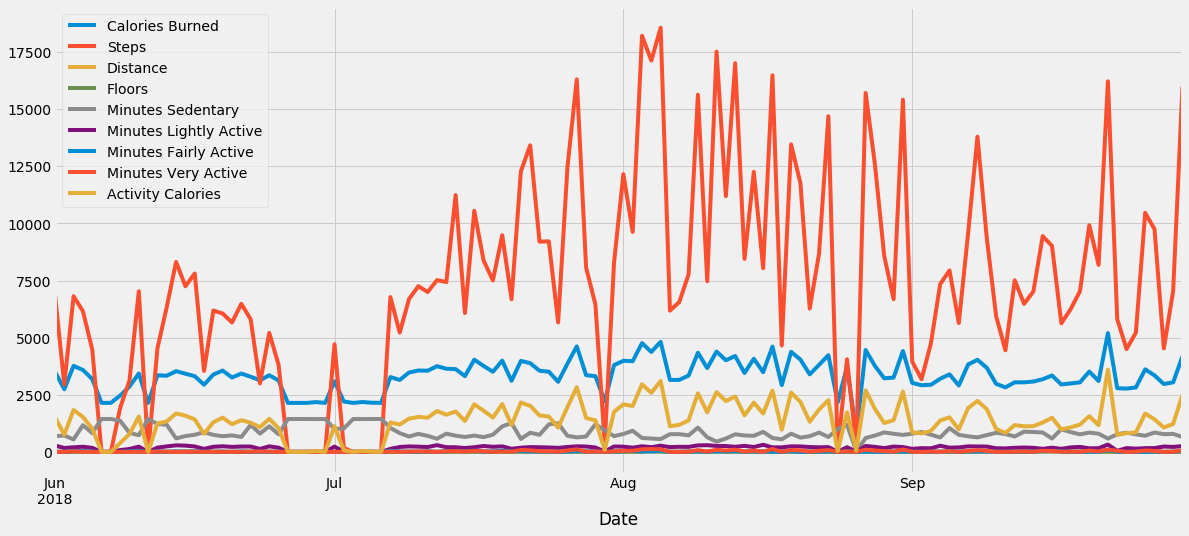

In [16]:
event_range.plot()

In [17]:
pre_event = df2[:'2018-08-26']

In [18]:
post_event = df2['2018-08-26':]

## Before the event

In [19]:
pre_event.describe()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,3261.845528,6147.813008,2.899837,5.398374,898.788618,169.926829,13.414634,19.626016,1245.699187
std,686.354029,4700.925257,2.217677,8.660954,280.654074,84.691065,14.641020,31.579563,762.028741
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000
25%,2890.000000,2851.000000,1.345000,0.500000,701.500000,130.000000,0.000000,0.000000,766.000000
50%,3324.000000,5879.000000,2.770000,3.000000,821.000000,198.000000,9.000000,6.000000,1289.000000
75%,3645.000000,8184.000000,3.860000,7.000000,1088.500000,230.000000,21.000000,21.500000,1730.500000
max,4818.000000,18565.000000,8.760000,78.000000,1440.000000,311.000000,67.000000,125.000000,3106.000000


In [ ]:
sns.heatmap(pre_event.corr())

## After the event

In [20]:
post_event.describe()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,3543.902913,11307.456311,5.378155,21.067961,695.330097,208.398058,16.572816,50.553398,1755.854369
std,580.780788,4502.931287,2.165243,35.262673,137.567266,57.587843,16.082875,36.483875,640.718720
min,799.000000,207.000000,0.100000,1.000000,28.000000,13.000000,0.000000,0.000000,51.000000
25%,3155.500000,8009.500000,3.825000,7.000000,620.000000,167.500000,6.500000,14.000000,1276.500000
50%,3517.000000,10729.000000,5.160000,11.000000,698.000000,209.000000,12.000000,48.000000,1689.000000
75%,3822.000000,14642.000000,7.005000,16.000000,781.500000,249.000000,20.500000,79.000000,2114.500000
max,5199.000000,25512.000000,12.000000,195.000000,1040.000000,349.000000,78.000000,154.000000,3596.000000


In [ ]:
sns.heatmap(post_event.corr())

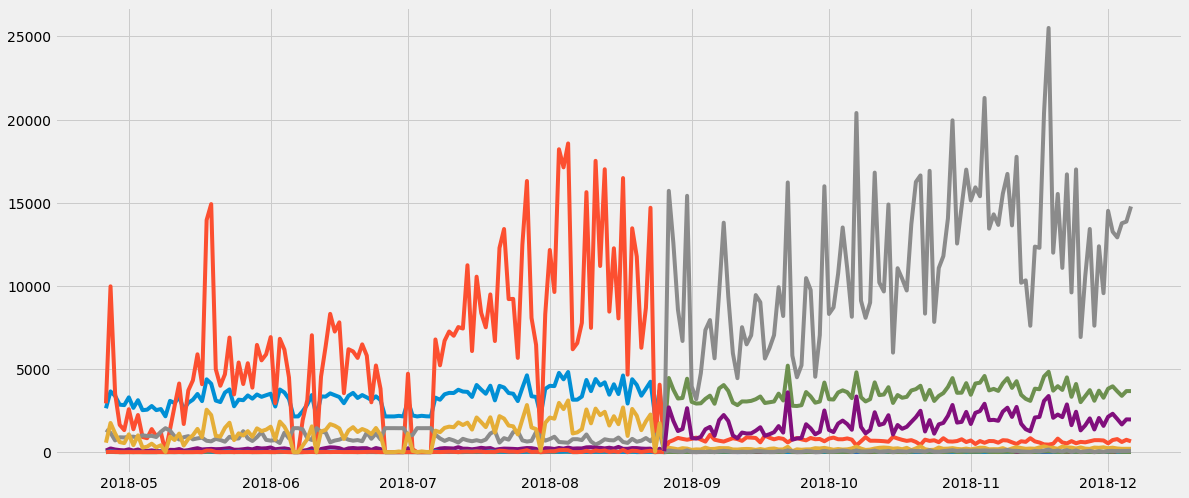

In [21]:
plt.pyplot.plot(pre_event)
plt.pyplot.plot(post_event)
plt.pyplotp.
plt.pyplot.show()

## Decomposition

In [39]:
all_time = seasonal_decompose(df2, model='additive')

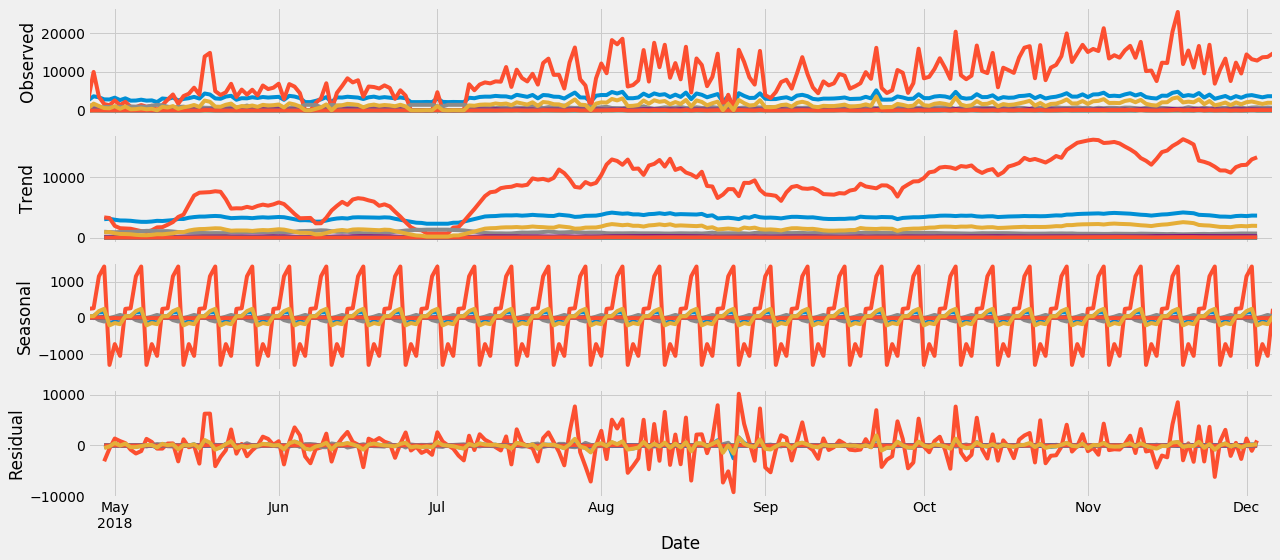

In [41]:
all_time.plot()
plt.pyplot.show()

Pre-Event

In [32]:
result = seasonal_decompose(pre_event, model='additive')

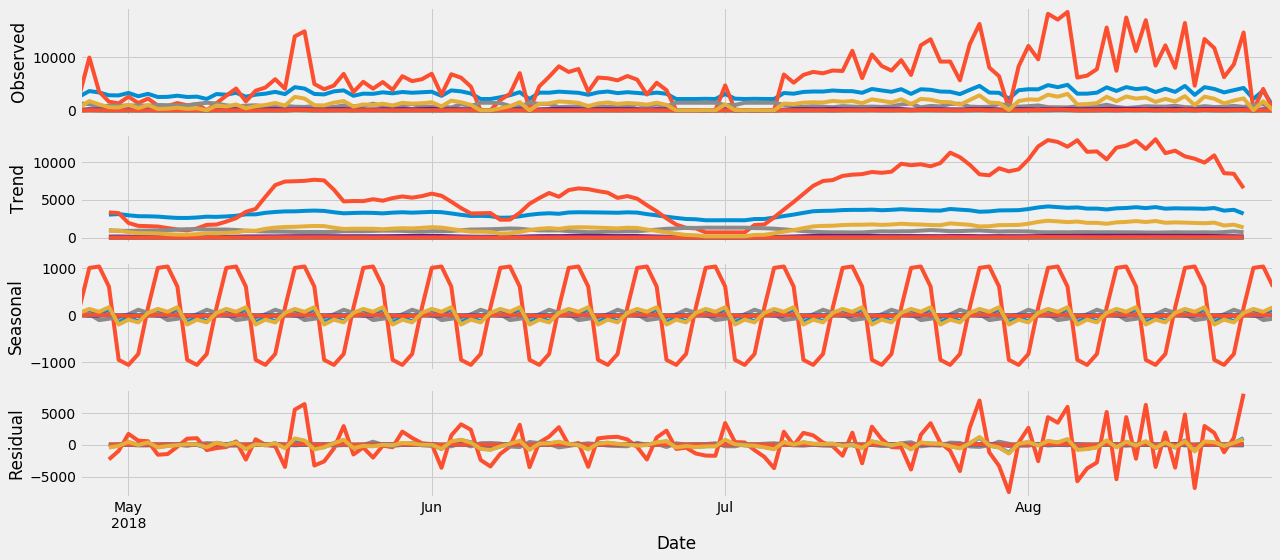

In [33]:
result.plot()
plt.pyplot.show()

Post-Event

In [36]:
result2 = seasonal_decompose(post_event, model='additive')

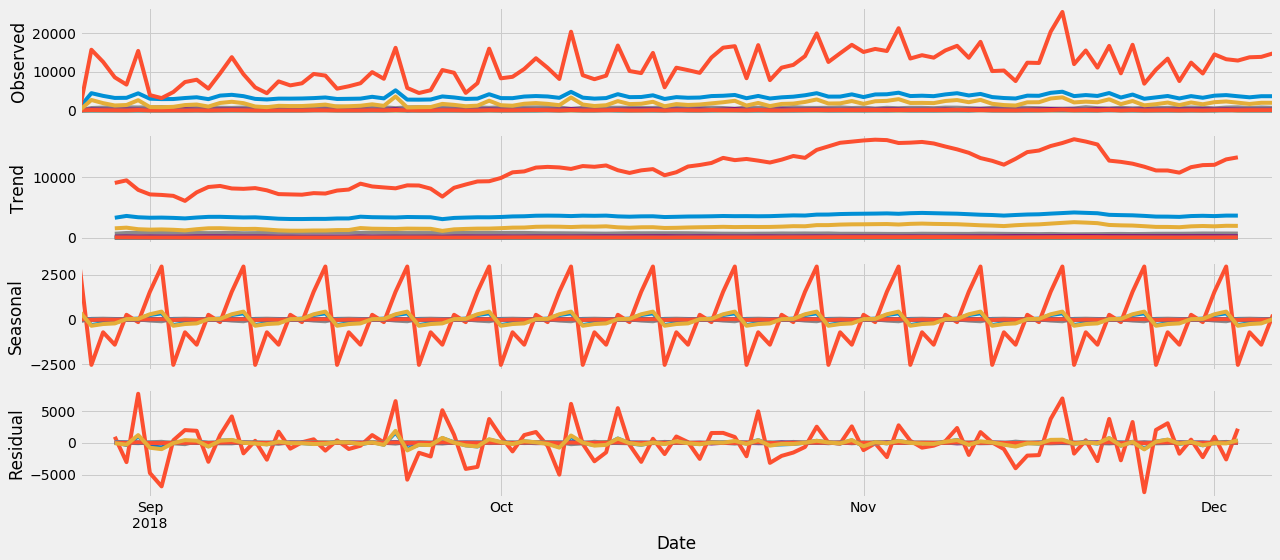

In [37]:
result2.plot()
plt.pyplot.show()

# FORECASTING

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


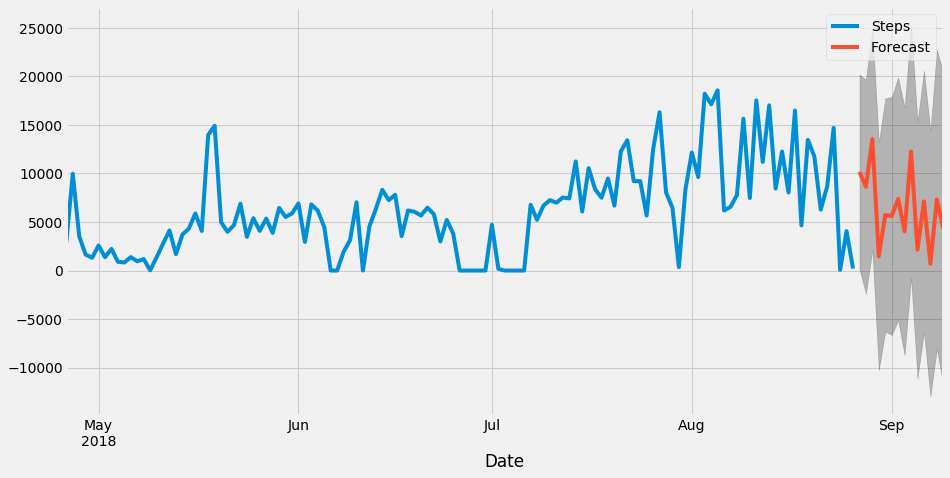

In [25]:
explore.time_predict(pre_event,'Steps',forecast=True, step_count=14)